# Your work here!

In [1]:
import numpy as np 
#import pandas as pd
#import torch, torch.nn as nn, time
#from torch.utils.data import Dataset, DataLoader
#from nnViz_pytorch import *
import matplotlib.pylab as plt
plt.style.use(['Solarize_Light2'])
N = 96   # time samples
S = 4    # number of different types of sensors 
F = 4    # fold for each types of sensors  
#CPU = torch.device('cpu')
%matplotlib inline
!pwd

/home/irina/Hackathon/environmental-hackathon


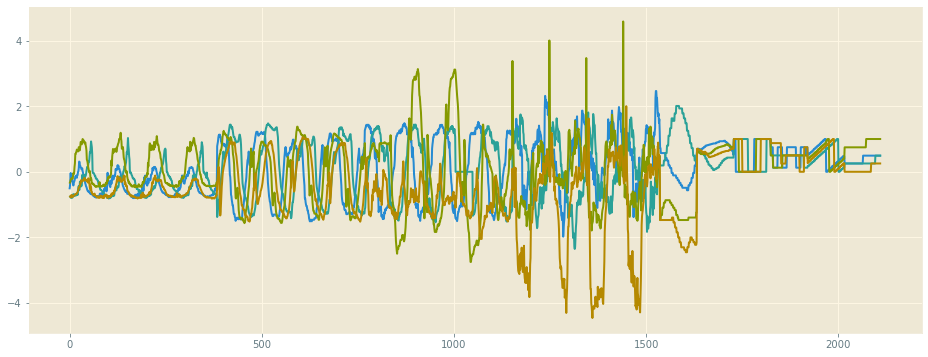

In [2]:
# For testing:
test = np.load("data/test_data_complete.npy")
d1 = test[20]            # regular
d2 = test[5502]          # broken sensor 
d3 = test[3050]          # deviates from prediction strongly
d4 = test[9298]          # deviates from prediction weakly

plt.figure(figsize=(16,6));
plt.plot(d1)
plt.plot(d2)
plt.plot(d3)
plt.plot(d4)

In [31]:
def broken_sensor(data):
    n = 45   # how many the same values in a row
    for i in range(N*F*S-n):
        d = np.array(data[i:i+n])
        if sum(abs(d - d[0])) == 0:  # should be replaced for a small epsilon 
            return True, i 
    return False, None    

def sumup(data):
    a =  np.array(data[:N*F*S]).reshape((F*S,N))
    b =  np.zeros(N*S)
    for i in range(F):
        c = np.median(a[i*S:(i+1)*S], axis=0) 
        b[i*N:(i+1)*N] = c 
    return b

In [32]:
# test 
for d in [d1,d2,d3,d4]:
    a, loc = broken_sensor(d)
    print(a, loc)


False None
True 1004
False None
False None


In [5]:
def deviation(a,b):
    c = np.array(a) - np.array(b)
    mse = np.square(c).mean(axis=None)
    dev = max(abs(c))
    return dev, mse

def deviation_stats(data):
    d = np.array(data[:N*F*S])
    p = sumup(d) 
    dev=np.zeros(S*F)
    mse=np.zeros(S*F)
    for j in range(S):
        p1 = p[j*N:(j+1)*N]
        for i in range(F):
            t1 = d[(j*4+i)*N:(j*4+i+1)*N]
            de = deviation(t1, p1)
            dev[j*4+i] = de[0]
            mse[j*4+i] = de[1]
    maxdev = np.zeros(S)
    mserro = np.zeros(S)
    
    for i in [0,1,2,3]:
        maxdev[i] = np.max(dev[i*4:(i+1)*4])
        mserro[i] = np.max(mse[i*4:(i+1)*4])    
            
    return maxdev, mserro

In [6]:
#test
for d in [d1,d2,d3,d4]:
    m, e = deviation_stats(d)
    print(m, e)

[0.22023471 0.38226504 0.35928825 1.02810018] [0.00158928 0.02591593 0.00716906 0.15093779]
[0.23994079 0.43135668 1.45869375 1.12132659] [0.00247307 0.03192164 0.43823072 0.18520026]
[0.30537736 0.51886701 2.73790877 1.16063921] [0.0035997  0.0520474  1.84668381 0.37894592]
[0.20910803 0.93039734 0.92283742 2.4012922 ] [0.00238715 0.11438647 0.13869279 0.57562404]


In [7]:
p1 = sumup(d1)
p1.shape

(384,)

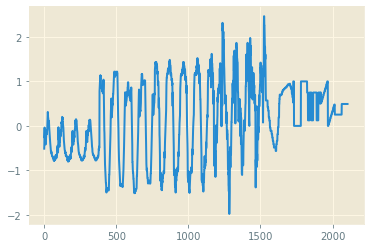

In [8]:
plt.plot(d1)


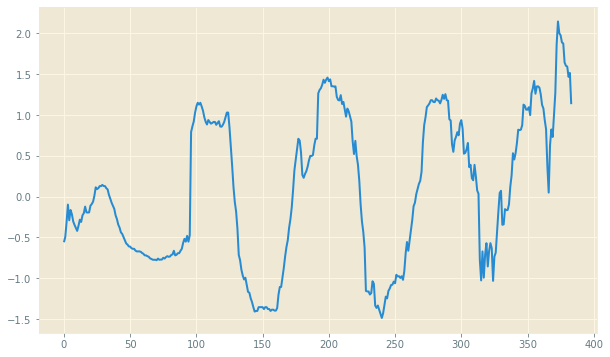

In [9]:
plt.figure(figsize=(10,6))
plt.plot(sumup(d1))

In [10]:
def renormalize(m1, e1):
    c1=   [ [ 0.28839485841634954 , 0.4106601124625037 ],
            [-0.002937341422468576, 0.993106182986244  ],
            [ 0.41749810213561706 , 0.3204305447688943 ],
            [-0.011760567673038876, 0.917422153284164  ],
            [ 0.38499685640094444 , 0.3402340562342016 ],
            [-0.012743657714150078, 0.8913527976604793 ],
            [ 1.2898320921433968  , 0.4206338721715384 ],
            [-0.005041096907687179, 0.975385708576683  ]]

    c2 = [  [ 0.026487705303107675, 1.1370754479374277  ],
            [-0.019393491812596867, 0.033247844603464784],
            [ 0.03955405650493912 , 0.34421708073584595 ],
            [-0.046724831911788736, 0.05708049310321512 ],
            [ 0.02844329106174288 , 0.3948530152585743  ],
            [-0.040518777472338036, 0.04171395534220852 ],
            [ 0.2606902174750526  , 0.41172501917005294 ],
            [-0.04012613756507658 , 0.25004625838260924 ]]
    
    m2 = ((m1 - c1[0][0])/c1[0][1] - c1[1][0])/c1[1][1]
    e2 = ((e1 - c2[0][0])/c2[0][1] - c2[1][0])/c2[1][1]
    return m2, e2

def apply_thr(data, th= 6.5):
    dev, mse = deviation_stats(data)
    for m1, e1 in zip(dev,mse):
        m2, e2 = renormalize(m1, e1)
        if m2 >= th: return True
        if e2 >= th: return True
    return False

In [11]:
dev, mse =  deviation_stats(d2)
print( dev, mse)
de1, ms1 = renormalize(dev, mse)
print(de1, ms1)

[0.23994079 0.43135668 1.45869375 1.12132659] [0.00247307 0.03192164 0.43823072 0.18520026]
[-0.11585201  0.35350118  2.87253938  2.04531257] [-0.05191777  0.72703533 11.47444364  4.78145598]


In [12]:
for d in [d1,d2,d3,d4]:
    a =  apply_thr(d, 8)
    print(a)

False
True
True
True
